**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

**Load the Seismic Data**

In [2]:
GroundAccel = pd.read_csv("El-Centro-2.txt", delimiter='\s+') # time [t] vs. g
GroundAccel["ug_ddot"] *= 9.81 # [m/s2]
GroundAccel.head(3) # Display first 3 rows to check the data

,t,ug_ddot
0,0.000,0.014715
1,0.005,0.020601
2,0.010,0.052974


**Plot the ground acceleration data**

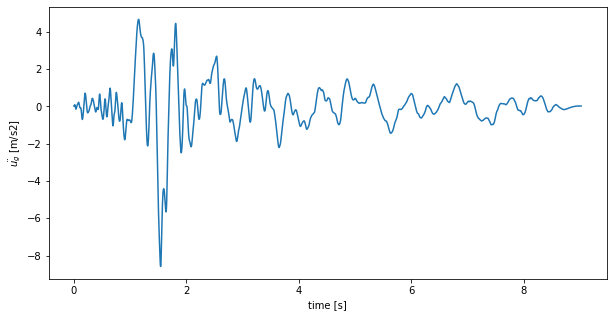

In [3]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(GroundAccel["t"], GroundAccel["ug_ddot"])
ax.set_xlabel("time [s]")
ax.set_ylabel("$\ddot{u_g}$ [m/s2]")
plt.show()

**A function to obtain recurrence coeff. (Aydınoğlu, 2003)**

In [4]:
def recurr_coeff(beta_ej, ksi, omega, deltat):
    if (abs(beta_ej)<1e-10):
        if (abs(ksi)<1e-10):
            A11 = 1
            A12 = deltat
            A21 = 0
            A22 = 1
            B11 = -(1./2.)*deltat**2
            B12 = -(1./6.)*deltat**2
            B21 = -A12
            B22 = B11/delta
            return [A11, A12, A21, A22, B11, B12, B21, B22]
        else:
            eta = 2*ksi*omega
            G = math.exp(-eta*deltat)
            A11 = 1
            A12 = (1-G)/eta
            A21 = 0
            A22 = G
            B11 = (A12-deltat)/eta
            B12 = -(B11/deltat+0.5*deltat)/eta
            B21 = -A12
            B22 = B11/deltat
            return [A11, A12, A21, A22, B11, B12, B21, B22]
    else:
        if (abs(beta_ej-ksi**2)<1e-10):
            A11 = (1+ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
            A12 = deltat*math.exp(-ksi*omega*deltat)
            A21 = -beta_ej*(omega**2)*A12
            A22 = (1-ksi*omega*deltat)*math.exp(-ksi*omega*deltat)
        else:
            if (beta_ej>ksi**2):
                omegaD = omega*(beta_ej-ksi**2)**0.5
                E = math.cos(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sin(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            else:
                omegaD = omega*(-beta_ej+ksi**2)**0.5
                E = math.cosh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
                F = math.sinh(omegaD*deltat)*math.exp(-ksi*omega*deltat)
            A11 = E+(ksi*omega/omegaD)*F
            A12 = F/omegaD
            A21 = -beta_ej*(omega**2)*A12
            A22 = E-(ksi*omega/omegaD)*F
        B11 = (A11-1)/(beta_ej*omega**2)
        B12 = (A12-2*ksi*omega*B11-deltat)/(beta_ej*(omega**2)*deltat)
        B21 = -A12
        B22 = B11/deltat
        return [A11, A12, A21, A22, B11, B12, B21, B22]  

**Define the function which performs time stepping**

In [5]:
def hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend):
    """"
    Inputs:
    T : initial period [s]
    ksi : linear damping coeff.
    alpha : post-yield stiffness ratio
    theta : stability coeff.
    fy_over_m : yield pseudo-acc. [m/s2]
    deltat : time step [s]
    tend : end time of simulation [s]
    
    Outputs:
    u_arr : displacements [m]
    u_dot_arr : velocities [m/s]
    u_ddot_arr : accelerations [m/s2]
    fs_over_m_arr : pseudo-acc.  [m/s2]
    t_arr : corresponding times [s]
    EI_over_m_arr : input energy per unit mass due to ground acc. [m2/s2]
    Ek_over_m_arr : kinetic energy per unit mass [m2/s2]
    Ed_over_m_arr : damping energy per unit mass [m2/s2]
    Ees_over_m_arr : elastic energy per unit mass [m2/s2]
    Eps_over_m_arr : plastic energy per unit mass [m2/s2]
    """
    omega = 2*math.pi/T # Initial natural freq.
    
    beta_ej_elastic = 1-theta # Effective stiffness ratio for elastic segments
    beta_ej_yielding = alpha-theta # Effective stiffness ratio for yielding segments
    
    t = 0 # Initial time
    u = 0 # Initial displacement
    u_dot = 0 # Initial velocity
    fs_over_m = 0 # Initial pseudo-acc.
    mode = "elastic" # Starting mode - elastic or yielding
    beta_ej = beta_ej_elastic # Initial effective stiffness ratio 
    ug_ddot = np.interp(t, GroundAccel["t"], GroundAccel["ug_ddot"]) # Ground accel at t=0
    uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u # Effective pseudo ground accel at t=0
    u_ddot = ug_ddot
    
    # Initiate arrays to store data for post-processing
    u_arr = [u]
    u_dot_arr = [u_dot]
    u_ddot_arr = [-uG_ddot]
    fs_over_m_arr = [fs_over_m]
    t_arr = [t]
    
    deltat_ref = deltat # Input time step to be used as reference.
                        # At the intersection points of linear segments,
                        # a smaller time step may be required. 
            
    Ek_over_m_arr = [0]
    Ed_over_m_arr = [0]
    EI_over_m_arr = [0]
    Ees_over_m_arr = [0]
    Eps_over_m_arr = [0]
    
    while (t<tend):
        t += deltat 
        
        # Save old solutions
        ug_ddot_old = ug_ddot
        u_old = u
        u_dot_old = u_dot
        u_ddot_old = u_ddot
        fs_over_m_old = fs_over_m
        
        # Calculate ground acceleration increment
        ug_ddot = np.interp(t, GroundAccel["t"], GroundAccel["ug_ddot"])
        delta_ug_ddot = ug_ddot-ug_ddot_old
        
        # Update u, u_dot and fs_over_m for elastic mode
        if (mode == "elastic"):
            AB = recurr_coeff(beta_ej, ksi, omega, deltat)
            u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
            u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
            u_ddot = -2*ksi*omega*u_dot-beta_ej*(omega**2)*u-uG_ddot-delta_ug_ddot
            fs_over_m += beta_ej*(omega**2)*(u-u_old)
            
            # Energy calculations
            Ek_over_m = 0.5*(u_ddot_old*u_dot_old+u_ddot*u_dot)*deltat 
            Ed_over_m = 2*ksi*omega*0.5*(u_dot_old**2+u_dot**2)*deltat
            EI_over_m = -0.5*(ug_ddot_old*u_dot_old+ug_ddot*u_dot)*deltat
            Ees_over_m = 0.5*(fs_over_m_old*u_dot_old+fs_over_m*u_dot)*deltat
            Eps_over_m = 0
            
            # Check for plastic transition
            fy_over_m_TOP = beta_ej_yielding*(omega**2)*u+(1-alpha)*fy_over_m
            fy_over_m_BOTTOM = beta_ej_yielding*(omega**2)*u-(1-alpha)*fy_over_m
            
            if (fs_over_m>fy_over_m_TOP or fs_over_m<fy_over_m_BOTTOM):
                if (abs(fs_over_m-fy_over_m_TOP)<1e-10 or abs(fs_over_m-fy_over_m_BOTTOM)<1e-10):
                    mode = "yielding"
                    beta_ej = beta_ej_yielding
                    deltat = deltat_ref
                else:
                    ug_ddot = ug_ddot_old
                    u = u_old
                    u_dot = u_dot_old
                    fs_over_m = fs_over_m_old
                    t -= deltat
                    deltat *= 0.9
                    continue
                    
        # Update u, u_dot and fs_over_m for plastic mode                    
        elif (mode == "yielding"): 
            AB = recurr_coeff(beta_ej, ksi, omega, deltat)
            u = AB[0]*u_old+AB[1]*u_dot_old+AB[4]*uG_ddot+AB[5]*delta_ug_ddot
            u_dot = AB[2]*u_old+AB[3]*u_dot_old+AB[6]*uG_ddot+AB[7]*delta_ug_ddot
            u_ddot = -2*ksi*omega*u_dot-beta_ej*(omega**2)*u-uG_ddot-delta_ug_ddot
            fs_over_m += beta_ej*(omega**2)*(u-u_old)
            
            # Energy calculations
            Ek_over_m = 0.5*(u_ddot_old*u_dot_old+u_ddot*u_dot)*deltat 
            Ed_over_m = 2*ksi*omega*0.5*(u_dot_old**2+u_dot**2)*deltat
            EI_over_m = -0.5*(ug_ddot_old*u_dot_old+ug_ddot*u_dot)*deltat
            Ees_over_m = 0
            Eps_over_m = 0.5*(fs_over_m_old*u_dot_old+fs_over_m*u_dot)*deltat
            
            # Check for elastic transition
            if ((u_dot>0 and u_dot_old<0) or (u_dot<0 and u_dot_old>0)):
                if abs(u_dot)<1e-10:
                    mode = "elastic"
                    beta_ej = beta_ej_elastic
                    deltat = deltat_ref
                else:
                    ug_ddot = ug_ddot_old
                    u = u_old
                    u_dot = u_dot_old
                    fs_over_m = fs_over_m_old
                    t -= deltat
                    deltat *= 0.9
                    continue
                    
        uG_ddot = ug_ddot+fs_over_m-beta_ej*(omega**2)*u # Calculate effective pseudo-acc.
        
        # Fill the arrays for post-processing
        u_arr.append(u)
        u_dot_arr.append(u_dot)
        u_ddot_arr.append(u_ddot+ug_ddot)
        fs_over_m_arr.append(fs_over_m)
        t_arr.append(t)
        
        Ek_over_m_arr.append(Ek_over_m_arr[-1]+Ek_over_m)
        Ed_over_m_arr.append(Ed_over_m_arr[-1]+Ed_over_m)
        EI_over_m_arr.append(EI_over_m_arr[-1]+EI_over_m)
        Ees_over_m_arr.append(Ees_over_m_arr[-1]+Ees_over_m)
        Eps_over_m_arr.append(Eps_over_m_arr[-1]+Eps_over_m)
        
    return u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, EI_over_m_arr, \
            Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr

**Inputs**

In [6]:
ksi = 0.003
alpha = 0.0
theta = 0.0
fy_over_m = 1e100
T = 3.71
tend = 9.02
deltat = 0.005

**Elastic response**

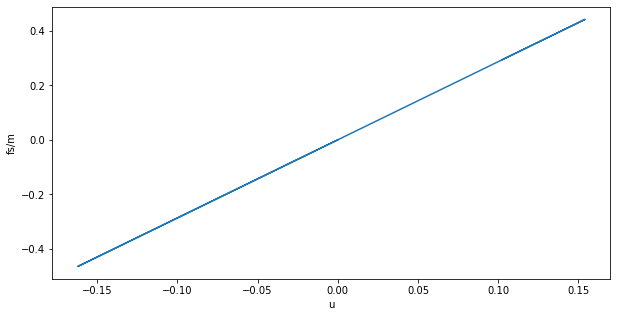

0.46475027296193716


In [7]:
u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(u_arr, fs_over_m_arr)
ax.set_xlabel("u")
ax.set_ylabel("fs/m")
plt.show()
    
fs_over_m_elasticMax = (max(abs(i) for i in fs_over_m_arr))
print(fs_over_m_elasticMax)

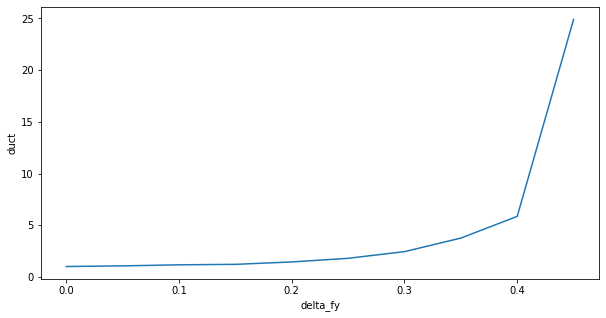

In [8]:
delta_fy = 0
delta_fy_arr = []
duct_arr = []
for i in range(10):
    delta_fy = 0.05*i
    fy_over_m = fs_over_m_elasticMax-delta_fy
    u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
    EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend) 
    
    ductility = (max(abs(i) for i in u_arr))/(fy_over_m/(2*math.pi/T)**2)
    
    delta_fy_arr.append(delta_fy)
    duct_arr.append(ductility)
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(delta_fy_arr, duct_arr)
ax.set_xlabel("delta_fy")
ax.set_ylabel("duct")
plt.show()    

1
2
3
4
5
6
7
4.003182756655523


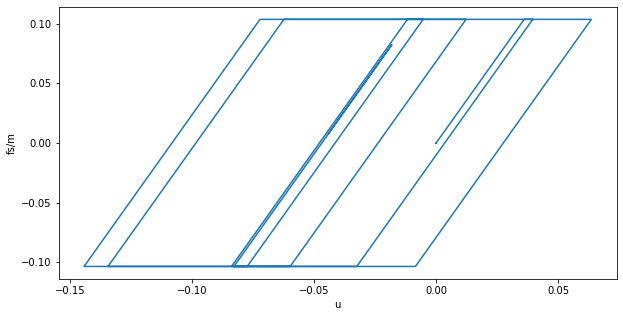

In [9]:
ksi = 0.003
alpha = 0.0
theta = 0.0
T = 3.71
tend = 9.02
deltat = 0.005

ductilityTar = 4
fy_over_m_TOP = fs_over_m_elasticMax
fy_over_m_BOTTOM = 0
fy_over_m = 0.5*(fy_over_m_TOP+fy_over_m_BOTTOM)

niter = 0
while True:
    
    u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
    EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)
    
    ductility = (max(abs(i) for i in u_arr))/(fy_over_m/(2*math.pi/T)**2)
    
    if abs(ductility-ductilityTar)<1e-2:
        break
    
    if ductility<ductilityTar:
        fy_over_m_TOP = fy_over_m
        fy_over_m = 0.5*(fy_over_m_TOP+fy_over_m_BOTTOM)
    else:
        fy_over_m_BOTTOM = fy_over_m
        fy_over_m = 0.5*(fy_over_m_TOP+fy_over_m_BOTTOM)
        
    niter+=1
    print(niter)
        
print(ductility)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(u_arr, fs_over_m_arr)
ax.set_xlabel("u")
ax.set_ylabel("fs/m")
plt.show()

**Newton-Raphson**

In [29]:
ksi = 0.003
alpha = 0.0
theta = 0.0
T = 3.71
tend = 9.02
deltat = 0.005
ductilityTar = 4

fy_over_m = 0.5*fs_over_m_elasticMax

u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
    hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)
    
ductility = (max(abs(i) for i in u_arr))/(fy_over_m/(2*math.pi/T)**2)

Err = ductility-ductilityTar

step = 1e-1
tol = 1e-2
maxiter = 1e3

niter = 0
while abs(Err)>tol:
    
    print(niter, ductility)
    
    fy_over_m_p = fy_over_m
    
    fy_over_m += step
    
    u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
    EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)
    
    ductility = (max(abs(i) for i in u_arr))/(fy_over_m/(2*math.pi/T)**2)
    
    ErrNew = ductility-ductilityTar
    
    J = (ErrNew-Err)/step
    
    dx = -Err/J
    
    fy_over_m = fy_over_m_p+dx
    
    if fy_over_m<0:
        fy_over_m = 1e-3
    
    u_arr, u_dot_arr, u_ddot_arr, fs_over_m_arr, t_arr, \
    EI_over_m_arr, Ek_over_m_arr, Ed_over_m_arr, Ees_over_m_arr, Eps_over_m_arr = \
        hysteresis_bilinear(T, ksi, alpha, theta, fy_over_m, deltat, tend)
    
    ductility = (max(abs(i) for i in u_arr))/(fy_over_m/(2*math.pi/T)**2)
    
    Err = ductility-ductilityTar
    
    niter += 1

print(ductility)

0 1.6477080143978045
1 355.27925362626803
2 4.061201497206153
3.9980813222040523
